# Proyecto Final: Telecomunicaciones
## Objetivo: Identificar operadores ineficaces
### Link GDrive: https://drive.google.com/file/d/154CTTjlpuPaa-5hSqdZlIPX4TBMujTNL/view

### Fase 1: Preprocesamiento y Limpieza de Datos

Asegurar la calidad de los datos antes del análisis:
* Cargar los datasets telecom_dataset_us.csv y telecom_clients.csv
* Revisar la estructura general (info, describe) y muestras de datos
* Convertir columnas al formato correspondiente (datetime, integer, float, etc.)
* Verificar valores nulos y su tratamiento (eliminar, cambiar a cero)

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# Importar datos
df = pd.read_csv('/datasets/telecom_dataset_us.csv')
df_clients = pd.read_csv('/datasets/telecom_clients_us.csv')

In [2]:
print(f"{'Dataframe Telecom':^50}")
print('-'*50)
df.info()
print('-'*50)
print(df.describe())
print('-'*50)
print(df.sample(5))
print('-'*50)
print('\n')
print(f"{'Dataframe Clients':^50}")
print('-'*50)
df_clients.info()
print('-'*50)
print(df_clients.describe())
print('-'*50)
print(df_clients.sample(5))
print('-'*50)

                Dataframe Telecom                 
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
--------------------------------------------------
             user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000 

In [3]:
#Cambio de tipos de datos y tx valores ausentes
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None) # Cambiar a datetime y eliminar la zona horaria
df = df.dropna(subset=['operator_id']) # Se eliminan los valores nulos de operator_id
df['operator_id'] = df['operator_id'].astype(int) # Cambio a tipo int
df['internal'] = df['internal'].astype('boolean') # Cambiar a tipo booleano
df = df.dropna(subset=['internal']) # Se eliminan valores nulos en internal

### Fase 2: Análisis Exploratorio de Datos (EDA)

Entender el comportamiento de los datos:
* Visualizar proporción de llamadas entrantes vs. salientes, internas vs. externas
* Analizar tiempos de espera: Histogramas e identificación de outliers
* Analizar llamadas perdidas: Calcular porcentaje de abandono

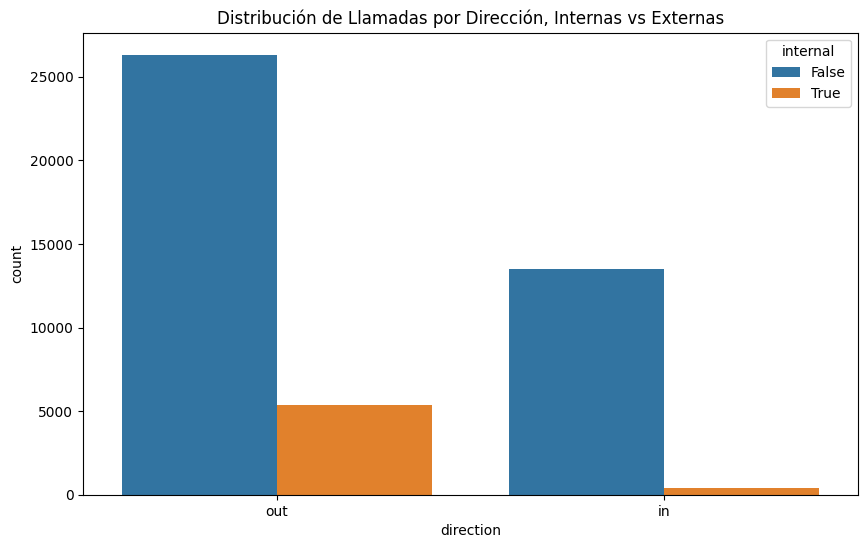

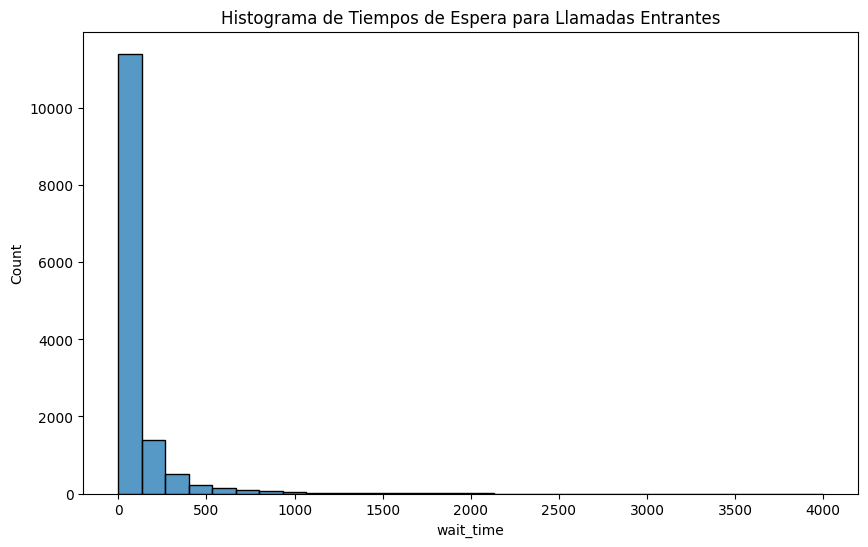


  Porcentaje de llamadas perdidas por dirección:  
--------------------------------------------------
direction
in      5.33
out    46.58
Name: is_missed_call, dtype: float64

   Percentil 90, 95 y 99 del tiempo de espera:    
--------------------------------------------------
Percentil 90: 660.0, 95: 1234.0, 99: 3530.24


In [4]:
# Distribución de llamadas por dirección
plt.figure(figsize=(10, 6))
sns.countplot(x='direction', hue='internal', data=df)
plt.title('Distribución de Llamadas por Dirección, Internas vs Externas')
plt.show()

# Histograma de tiempos de espera (para llamadas entrantes)
df['wait_time'] = df['total_call_duration'] - df['call_duration']
plt.figure(figsize=(10, 6))
sns.histplot(df[df['direction'] == 'in']['wait_time'], bins=30)
plt.title('Histograma de Tiempos de Espera para Llamadas Entrantes')
plt.show()

# Identificar llamadas perdidas
miss_call = round(df.groupby('direction')['is_missed_call'].mean()*100,2)
print(f"\n{'Porcentaje de llamadas perdidas por dirección:':^50}")
print('-'*50)
print(miss_call)

# Tiempos de espera
print(f"\n{'Percentil 90, 95 y 99 del tiempo de espera:':^50}")
print('-'*50)
print("Percentil 90: {}, 95: {}, 99: {:.2f}".format(
    np.percentile(df['wait_time'], [90])[0], np.percentile(df['wait_time'], [95])[0], np.percentile(df['wait_time'], [99])[0]
))

### Fase 3: Criterios de ineficacia

Buscar KPIs y rangos que indican ineficacia de las operadoras:
* Agrupar por operador los datos
* Calcular porcentaje de llamadas entrantes perdidas
* Calcular el tiempo de espera promedio
* Calcular el volumen de llamadas salientes
* Definir rangos de ineficiencia: Investigar en diferentes fuentes qué se considera ineficiente en una operadora

In [5]:
# Métricas por operador

df['missed_count'] = df['calls_count'].where(df['is_missed_call'], 0)
df['in_count'] = df['calls_count'].where(df['direction']=='in', 0)
df['in_count_miss'] = df['calls_count'].where((df['direction']=='in')&(df['is_missed_call']==True), 0)
df['out_count'] = df['calls_count'].where(df['direction']=='out', 0)
df['out_count_miss'] = df['calls_count'].where((df['direction']=='out')&(df['is_missed_call']==True), 0)
df['out_count_succ'] = df['calls_count'].where((df['direction']=='out')&(df['is_missed_call']==False), 0)
metrics = df.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('missed_count','sum'),
    avg_wait_time=('wait_time', 'mean'),
    in_calls=('in_count','sum'),
    out_calls=('out_count','sum'),
    in_calls_miss=('in_count_miss','sum'),
    out_calls_miss=('out_count_miss','sum'),
    out_calls_succ=('out_count_succ','sum')
).reset_index()

metrics['miss_rate'] = metrics['missed_calls'] / metrics['total_calls']
metrics['in_rate_miss'] = (metrics['in_calls_miss'] / metrics['in_calls']).fillna(0)
metrics['out_rate_miss'] = (metrics['out_calls_miss'] / metrics['out_calls']).fillna(0)
metrics['out_rate_succ'] = (metrics['out_calls_succ'] / metrics['out_calls']).fillna(0)
print(metrics)

      operator_id  total_calls  missed_calls  avg_wait_time  in_calls  \
0          879896         1131           255     110.671875        60   
1          879898         7973          2594     451.860000       117   
2          880020           54            30      15.181818         8   
3          880022          219           118      57.565789         8   
4          880026         2439           696     121.171717        25   
...           ...          ...           ...            ...       ...   
1087       972410           77            37     374.500000         0   
1088       972412           61            25     210.000000         1   
1089       972460           70            28      89.000000         2   
1090       973120            3             2      10.000000         0   
1091       973286            2             0      88.000000         2   

      out_calls  in_calls_miss  out_calls_miss  out_calls_succ  miss_rate  \
0          1071              0             255

In [6]:
# Rangos de ineficiencia (según bibliografía)
metrics['inef_miss'] = metrics['in_rate_miss'] > 0.10 # Procentaje de llamadas entrantes perdidas mayor al 10%
metrics['inef_wait'] = metrics['avg_wait_time'] > 30 # Tiempo de espera mayor a 30 segundos
metrics['inef_out'] = metrics['out_rate_succ'] < 0.03 # Porcentaje de exito en llamadas salientes menor al 3%

### Fase 4: Identificar y clasificar

Generar la lista de operadores ineficaces:
* Aplicar filtros para etiquetar a cada operador según los umbrales investigados
* Crear una tabla con los IDs de los operadores ineficaces y su razón (tasa alta de llamadas perdidas, espera prolongada, número reducido de llamadas salientes conectadas)

In [7]:
# Etquetar a los operadores
metrics['ineficiente'] = (
    metrics['inef_miss'] |
    metrics['inef_wait'] |
    metrics['inef_out']
)

operadores = metrics[['operator_id','inef_miss','inef_wait','inef_out','ineficiente']]
print('\n')
print('*'*63)
print(f"{'Lista de operadores etiquetados segun eficiencia':^60}")
print('-'*63)
print(operadores)



***************************************************************
      Lista de operadores etiquetados segun eficiencia      
---------------------------------------------------------------
      operator_id  inef_miss  inef_wait  inef_out  ineficiente
0          879896      False       True     False         True
1          879898      False       True     False         True
2          880020      False      False     False        False
3          880022      False       True     False         True
4          880026      False       True     False         True
...           ...        ...        ...       ...          ...
1087       972410      False       True     False         True
1088       972412      False       True     False         True
1089       972460      False       True     False         True
1090       973120      False      False     False        False
1091       973286      False       True      True         True

[1092 rows x 5 columns]


In [8]:
print('Operadores ineficientes encontrados:')
print(len(operadores[operadores['ineficiente']==True]))
print('\nOperadores eficientes:')
print(len(operadores[operadores['ineficiente']==False]))

Operadores ineficientes encontrados:
887

Operadores eficientes:
205


In [9]:
# Razón de su ineficiencia
inef_metrics=metrics[metrics['ineficiente']==True]
print(inef_metrics.groupby('ineficiente').agg(
    llamadas_perdidas=('inef_miss', 'sum'),
    espera_prolongada=('inef_wait','sum'),
    pocas_llamadas_salientes_exitosas=('inef_out', 'sum')
))

             llamadas_perdidas  espera_prolongada  \
ineficiente                                         
True                        31                707   

             pocas_llamadas_salientes_exitosas  
ineficiente                                     
True                                       279  


In [10]:
# Ver si la tarifa influye
price = metrics.merge(df[['operator_id','user_id']], on='operator_id',how='left')
price = price.merge(df_clients[['user_id','tariff_plan']], on='user_id', how='left')
price = price.drop_duplicates()
price=price.groupby(['ineficiente','tariff_plan']).size().reset_index(name='cantidad')

## Sumar por tarifa y eficiencia 
totales = price.groupby('tariff_plan')['cantidad'].sum() 
eficientes = price.loc[~price['ineficiente']].groupby('tariff_plan')['cantidad'].sum()

## Calcular porcentaje 
porcentaje = ((eficientes / totales * 100).round(2)).reset_index()
porcentaje.columns = ['tarifa','pct %']
print('Tarifas de las compañias')
print(price)
print('\n')
print('Porcentaje de tarifas que son eficientes')
print(porcentaje)

Tarifas de las compañias
   ineficiente tariff_plan  cantidad
0        False           A        42
1        False           B        86
2        False           C        77
3         True           A       268
4         True           B       309
5         True           C       310


Porcentaje de tarifas que son eficientes
  tarifa  pct %
0      A  13.55
1      B  21.77
2      C  19.90


### Fase 5: Prueba de Hipótesis Estadísticas

Comparar los operadores eficaces e ineficaces para demostrar estadísticamente que hay diferencias:
* El plan tarifario influye en la eficiencia: usaremos Z-test
* Proporción de llamadas perdidas: usar z-test porque trabajamos con proporciones de eventos.
* Tiempo de espera promedio: usar t-test porque queremos comparar medias de dos grupos cuando los datos son normales o el tamaño de muestra es grande, Mann‑Whitney por si los datos tienen distribuciones muy sesgadas (colas largas, outliers).
* Proporción de llamadas salientes conectadas: usar z-test porque trabajamos con proporciones de eventos.

In [11]:
# La tarifa B es mejor z-test
## éxitos y totales
A_suc = price.loc[(price['tariff_plan'] == 'A') & (price['ineficiente'] == False), 'cantidad'].sum()
A_nob = price.loc[price['tariff_plan'] == 'A', 'cantidad'].sum()
B_suc = price.loc[(price['tariff_plan'] == 'B') & (price['ineficiente'] == False), 'cantidad'].sum()
B_nob = price.loc[price['tariff_plan'] == 'B', 'cantidad'].sum()
C_suc = price.loc[(price['tariff_plan'] == 'C') & (price['ineficiente'] == False), 'cantidad'].sum()
C_nob = price.loc[price['tariff_plan'] == 'C', 'cantidad'].sum()

def hypo_Z(sucess1,sucess2,nob1,nob2):
    alpha=0.05
    stat, pval = proportions_ztest([sucess1,sucess2],[nob1,nob2])
    print("p-value:", pval)
    if pval < alpha:
        print('Se rechaza la hipótesis nula. Hay una diferencia significativa.')
    else:
        print('No se rechaza la hipótesis nula. No hay una diferencia significativa.')
print('Pruebas para el plan tarifario:\n')
print('Tarifa A vs B')
print('-'*30)
hypo_Z(A_suc,B_suc,A_nob,B_nob)
print('\n')
print('Tarifa B vs C')
print('-'*30)
hypo_Z(B_suc,C_suc,B_nob,C_nob)
print('\n')
print('Tarifa A vs C')
print('-'*30)
hypo_Z(A_suc,C_suc,A_nob,C_nob)

Pruebas para el plan tarifario:

Tarifa A vs B
------------------------------
p-value: 0.00492975421792783
Se rechaza la hipótesis nula. Hay una diferencia significativa.


Tarifa B vs C
------------------------------
p-value: 0.5185630978669551
No se rechaza la hipótesis nula. No hay una diferencia significativa.


Tarifa A vs C
------------------------------
p-value: 0.026866679230498562
Se rechaza la hipótesis nula. Hay una diferencia significativa.


In [12]:
# llamadas entrantes perdidas z-test
efi_miss_suc= metrics.loc[(metrics['ineficiente'] == False), 'in_calls_miss'].sum()
efi_nob = metrics.loc[(metrics['ineficiente'] == False), 'in_calls'].sum()
inef_miss_suc = metrics.loc[(metrics['ineficiente'] == True), 'in_calls_miss'].sum()
inef_nob = metrics.loc[(metrics['ineficiente'] == True), 'in_calls'].sum()

print('Prueba Z-test para la proporcion de llamadas perdidas')
print('-'*60)
hypo_Z(efi_miss_suc,inef_miss_suc,efi_nob,inef_nob)

# llamadas salientes z-test
efi_out_suc = metrics.loc[(metrics['ineficiente'] == False), 'out_calls_succ'].sum()
efi_out_nob = metrics.loc[(metrics['ineficiente'] == False), 'out_calls'].sum()
inef_out_suc = metrics.loc[(metrics['ineficiente'] == True), 'out_calls_succ'].sum()
inef_out_nob = metrics.loc[(metrics['ineficiente'] == True), 'out_calls'].sum()

print('\n\nPrueba Z-test para la proporcion de llamadas salientes')
print('-'*60)
hypo_Z(efi_out_suc,inef_out_suc,efi_out_nob,inef_out_nob)

# Tiempo de espera t-test
alpha=0.05
wait_efi = metrics.loc[(metrics['ineficiente'] == False), 'avg_wait_time']
wait_inef = metrics.loc[(metrics['ineficiente'] == True), 'avg_wait_time']

print('\n\nPrueba T-test para el tiempo de espera promedio')
print('-'*60)
t_stat, p_val = stats.ttest_ind(wait_efi, wait_inef)
print(p_val)
if p_val < alpha:
    print('Se rechaza la hipótesis nula. Hay una diferencia significativa.')
else:
    print('No se rechaza la hipótesis nula. No hay una diferencia significativa.')

# Tiempo de espera Mann U
print('\n\nPrueba Mann‑Whitney para el tiempo de espera promedio')
print('-'*60)
m_stat, p_val_m= stats.mannwhitneyu(wait_efi, wait_inef)
print(p_val_m)
if p_val_m < alpha:
    print('Se rechaza la hipótesis nula. Hay una diferencia significativa.')
else:
    print('No se rechaza la hipótesis nula. No hay una diferencia significativa.')

Prueba Z-test para la proporcion de llamadas perdidas
------------------------------------------------------------
p-value: 0.16792833116934802
No se rechaza la hipótesis nula. No hay una diferencia significativa.


Prueba Z-test para la proporcion de llamadas salientes
------------------------------------------------------------
p-value: 6.841226053640464e-144
Se rechaza la hipótesis nula. Hay una diferencia significativa.


Prueba T-test para el tiempo de espera promedio
------------------------------------------------------------
4.052657075093577e-10
Se rechaza la hipótesis nula. Hay una diferencia significativa.


Prueba Mann‑Whitney para el tiempo de espera promedio
------------------------------------------------------------
3.908638556413835e-65
Se rechaza la hipótesis nula. Hay una diferencia significativa.


In [13]:
print('Tiempo de espera promedio')
print('eficientes:', round(wait_efi.mean(),2))
print('ineficientes',round(wait_inef.mean(),2))

Tiempo de espera promedio
eficientes: 18.51
ineficientes 261.16


Presentacion sin formato: https://docs.google.com/document/d/1NuWcXwXHxus1uHWL4Laupd17QOfqByQ6/edit